Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Simulate data for ancient and moderate strength selection selrange = seq 0 200 200 / timerange = 0.1 100kya
*   Build and compile baseline model.


*   Train model on training data and gather metrics.

*   Test trained network on unseen data.
*  
This notebook seeks to utilise the optimsied hyperpamaters achived by bayseian optimisation where optimisation was done on 5 batches of data













In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/Opt_1/Ancient_Moderate



Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 2751, done.
remote: Counting objects: 100% (624/624), done.
remote: Compressing objects: 100% (415/415), done.
remote: Total 2751 (delta 304), reused 446 (delta 208), pack-reused 2127
Receiving objects: 100% (2751/2751), 4.74 GiB | 29.25 MiB/s, done.
Resolving deltas: 100% (690/690), done.
Updating files: 100% (423/423), done.
/content/EvoNet-CNN-Insight/Opt_1/Ancient_Moderate


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split


import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

In [3]:
%run -i ../../ImaGene.py

ImaGene uses msms to run simulations for training. Use ../generate_dataset.sh with ../params.txt (modify as needed).

 simulates 200,000 loci (80kbp) under neutral evolution or positive selection (1.5% selection coefficient). Mutation rate: 1.5e-8, recombination rate: 1e-8. Model follows Marth et al. 2004, sampling 198 chromosomal copies.

Specify directories for msms and simulation storage, then run the command. The script splits simulations into batches for training.

In [5]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_Ancient_moderate.txt".split());

In [6]:
path = './'

In [7]:

path_sim = './'

In [8]:
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Populate an ImaGene object by specifying the variable to estimate (selection_coeff_hetero) and the number of data points per class. Use 8000 data points per class as an example.

In [9]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000);

In [10]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');


In [11]:
gene_sim.resize((198, 192));

In [12]:
gene_sim.convert(flip=True);


shuffle images before using them for training network.


In [13]:
gene_sim.subset(get_index_random(gene_sim));

In [14]:
gene_sim.targets = to_binary(gene_sim.targets);

In [15]:
gene_sim.save(file=path + 'gene_sim.binary')

0

In [16]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

Build and compile the model.

In [17]:


# Define the CNN model based on the optimal parameters for Scenario AM
model = models.Sequential([
    layers.Conv2D(filters=17, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=9.299115750707925e-06, l2=1.2459203031568373e-06),
                  padding='valid', input_shape=gene_sim.data.shape[1:]),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=93, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=9.299115750707925e-06, l2=1.2459203031568373e-06),
                  padding='valid'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=106, kernel_size=(3, 3), strides=1, activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=9.299115750707925e-06, l2=1.2459203031568373e-06),
                  padding='valid'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model with the specified learning rate
adam_optimizer = optimizers.Adam(learning_rate=0.0001358195436069012)
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 17)      170       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 17)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 93)        14322     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 93)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 106)       88828     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 106)       0

summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 17)      170       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 17)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 93)        14322     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 93)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 106)       88828     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 106)       0

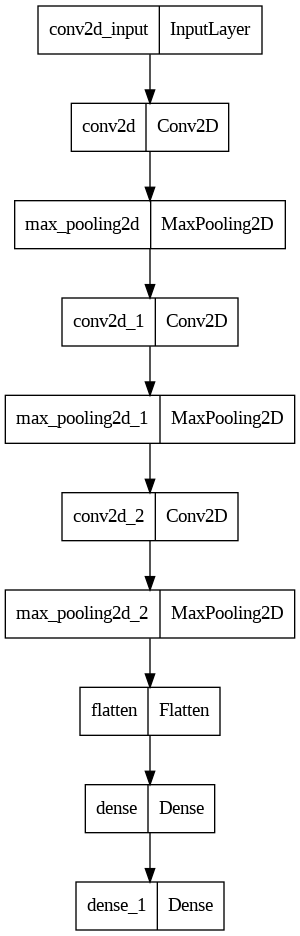

In [18]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [19]:
net_LCT = ImaNet(name='[C17+P][C93+P][C106+P]+D128+D1')

In [20]:
from IPython.display import Javascript, display

def keep_alive():
    display(Javascript('''
        function ClickConnect() {
          console.log("Clicked on connect button to prevent timeout");
          document.querySelector("colab-toolbar-button#connect").click();
        }
        setInterval(ClickConnect, 60000); // 60 seconds
    '''))

keep_alive()


<IPython.core.display.Javascript object>

train batches from 1-9

1
113/113 [==============================] - 578s 5s/step - loss: 0.7217 - accuracy: 0.5337 - val_loss: 0.6914 - val_accuracy: 0.6000
2
113/113 [==============================] - 574s 5s/step - loss: 0.6446 - accuracy: 0.6339 - val_loss: 0.5986 - val_accuracy: 0.6913
3
113/113 [==============================] - 567s 5s/step - loss: 0.5990 - accuracy: 0.6831 - val_loss: 0.5471 - val_accuracy: 0.7262
4
113/113 [==============================] - 571s 5s/step - loss: 0.5606 - accuracy: 0.7133 - val_loss: 0.5600 - val_accuracy: 0.6963
5
113/113 [==============================] - 577s 5s/step - loss: 0.5351 - accuracy: 0.7399 - val_loss: 0.5265 - val_accuracy: 0.7513
6
113/113 [==============================] - 579s 5s/step - loss: 0.5472 - accuracy: 0.7194 - val_loss: 0.5278 - val_accuracy: 0.7350
7
113/113 [==============================] - 571s 5s/step - loss: 0.5322 - accuracy: 0.7300 - val_loss: 0.5105 - val_accuracy: 0.7563
8
113/113 [==============================] - 573s 5s/step - lo

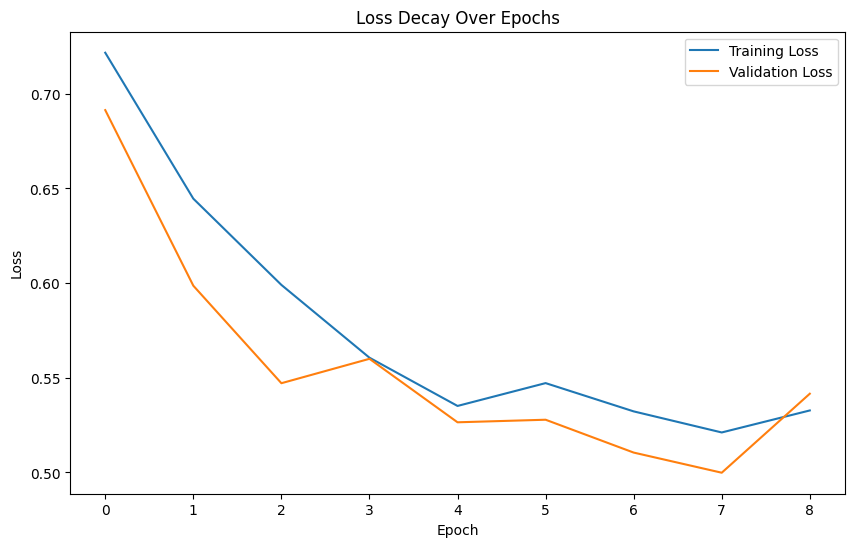

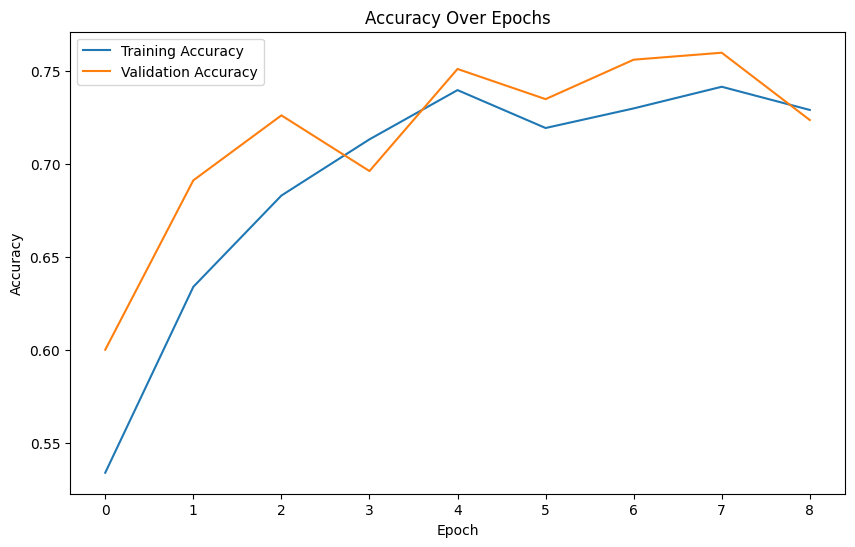

In [21]:
import csv


total_epochs = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []

i = 1
while i < 10:
    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Append the loss, validation loss, accuracy, and validation accuracy values for each epoch
    losses.extend(score.history['loss'])
    val_losses.extend(score.history['val_loss'])
    accuracies.extend(score.history['accuracy'])
    val_accuracies.extend(score.history['val_accuracy'])

    # Update the total number of epochs trained
    total_epochs += len(score.history['loss'])

    net_LCT.update_scores(score)

    i += 1

# Print the total number of epochs
print(f'Total epochs trained: {total_epochs}')

# Save the loss, validation loss, accuracy, and validation accuracy to a CSV file
with open('training_metrics.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    for epoch in range(total_epochs):
        training_loss = losses[epoch] if epoch < len(losses) else ''
        validation_loss = val_losses[epoch] if epoch < len(val_losses) else ''
        training_accuracy = accuracies[epoch] if epoch < len(accuracies) else ''
        validation_accuracy = val_accuracies[epoch] if epoch < len(val_accuracies) else ''
        csvwriter.writerow([epoch + 1, training_loss, validation_loss, training_accuracy, validation_accuracy])

# Plot the loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Decay Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

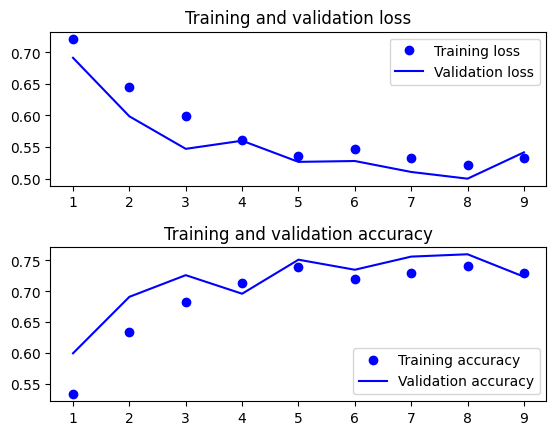

0

In [22]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [23]:
model.save(path + 'model.AM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model = load_model(path + 'model.AM.h5')

You can also save the network itself (and load it).

In [25]:
net_LCT.save(path + 'net_LCT.AM');

In [26]:
net_LCT = load_imanet(path + 'net_LCT.AM')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [27]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=8000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test)
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [28]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test)  # it will report [loss, accuracy]



[0.5222734808921814, 0.7421249747276306]


250/250 [==============================] - 181s 724ms/step


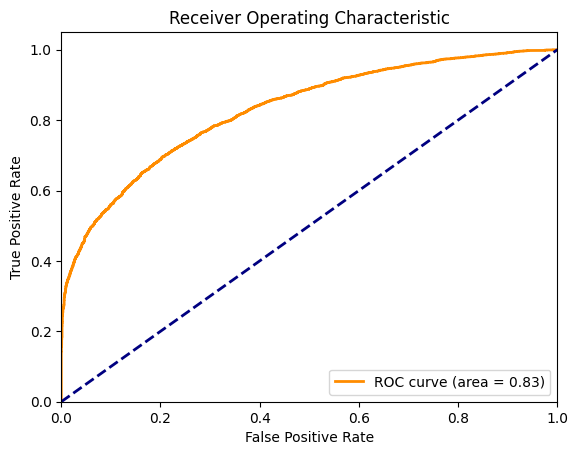

Sensitivity (Recall): 0.73
Specificity: 0.75
Precision: 0.75
F1 Score: 0.74


In [29]:
# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

250/250 [==============================] - 178s 712ms/step


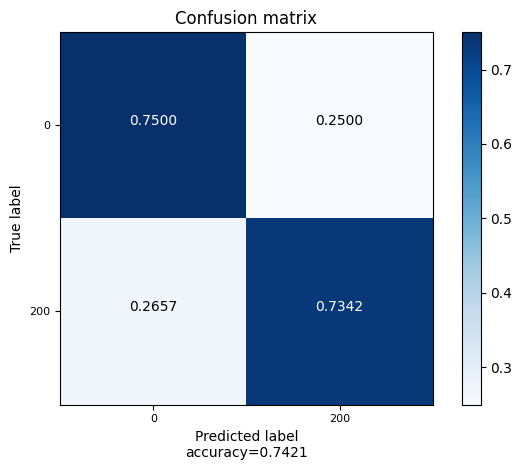

0

In [30]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)